# Table of Contents

1. [Imports](#Imports)
2. [TfidfVectorizer and MultinomialNB](#TfidfVectorizer-and-MultinomialNB)
3. [TfidfVectorizer and RandomTreesClassifier](#TfidfVectorizer-and-RandomTreesClassifier)
4. [TfidfVectorizer and LogisticRegression](#TfidfVectorizer-and-LogisticRegression)

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('./data/subreddits_EDA.csv')

In [3]:
print(df.shape)
df.head()

(16533, 9)


,subreddit,author,title,selftext,score,created_utc,eastern_time,post_word_count,title_word_count
0,Oxygennotincluded,TrumpByPublicOpinion,Mod Idea - In game Programmable Logic Controllers,"Hey everyone,\n\nBeen playing the game some ti...",1,1599762597,2020-09-10 14:29:57,108,8
1,Oxygennotincluded,DaHedgehog27,Mod Request - Removing Construction Supply fro...,I have zero clue when it comes to modding this...,1,1599752065,2020-09-10 11:34:25,104,8
2,Oxygennotincluded,KittehNevynette,Fertiliser flatulence power question. How much?,I saw a YT video where fertiliser synthesisers...,1,1599745896,2020-09-10 09:51:36,159,6
3,Oxygennotincluded,Turalyon135,Automation question,Is there a way using a gate or any kind to hav...,1,1599737435,2020-09-10 07:30:35,148,2
4,Oxygennotincluded,FoxRealistic3370,Perseverance or Experience,SOOOOO im on about cycle 1500 of my first base...,1,1599730988,2020-09-10 05:43:08,294,3


In [4]:
X = df['selftext']
y = df['subreddit']

In [5]:
y.value_counts(normalize =True)

Oxygennotincluded    0.549205
RimWorld             0.450795
Name: subreddit, dtype: float64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 3000, stratify=y)

# TfidfVectorizer and MultinomialNB

In [7]:
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

params_tvec = {
    'tvec__max_features': [10_000, 15_000],
    'tvec__stop_words': ['english'],
    'tvec__strip_accents': [None, 'unicode'],
    'tvec__max_df': [1.0, 0.98]
}

In [8]:
cross_val_score(pipe_tvec, X_train, y_train, scoring='accuracy').mean()

0.9036222332105819

In [9]:
gs_tvec = GridSearchCV(pipe_tvec,
                      params_tvec,
                      cv = 5,
                      verbose = 1)

In [10]:
%%time
gs_tvec.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   47.5s finished


CPU times: user 45.1 s, sys: 672 ms, total: 45.8 s
Wall time: 48.6 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [1.0, 0.98],
                         'tvec__max_features': [10000, 15000],
                         'tvec__stop_words': ['english'],
                         'tvec__strip_accents': [None, 'unicode']},
             verbose=1)

In [11]:
gs_tvec.best_params_

{'tvec__max_df': 1.0,
 'tvec__max_features': 10000,
 'tvec__stop_words': 'english',
 'tvec__strip_accents': 'unicode'}

In [12]:
gs_tvec.score(X_train, y_train), gs_tvec.score(X_test, y_test)

(0.9464472941366239, 0.9245283018867925)

In [13]:
preds_tvec = gs_tvec.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

Text(0.5, 1.0, 'Confusion Matrix for\nTfidfVectorizer and MultinomialNB')

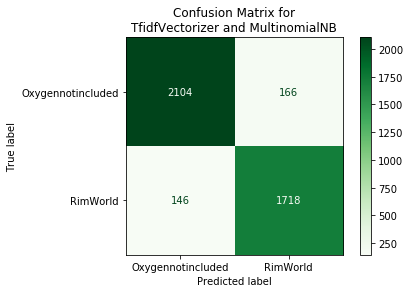

In [14]:
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap= "Greens", values_format = 'd');
plt.title("Confusion Matrix for\nTfidfVectorizer and MultinomialNB", fontsize=12)

In [15]:
pred_proba_tvec = [i[1] for i in gs_tvec.predict_proba(X_test)]

pred_df_tvec = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba_tvec})

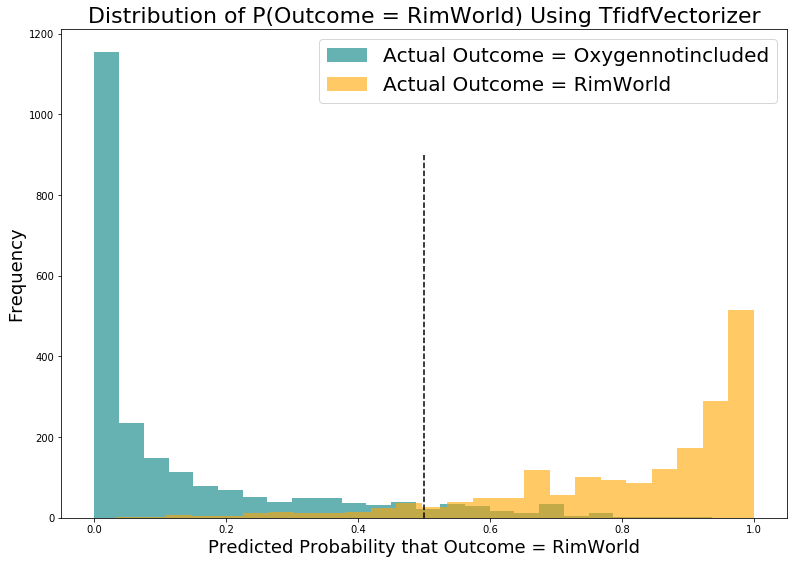

In [16]:
# Code adapted from global lect: Classification Metrics II

# Create figure.
plt.figure(figsize = (13,9))

# Create two histograms of observations.
plt.hist(pred_df_tvec[pred_df_tvec['true_values'] == 'Oxygennotincluded']['pred_probs'],
         bins=25,
         color='teal',
         alpha = 0.6,
         label='Actual Outcome = Oxygennotincluded')
plt.hist(pred_df_tvec[pred_df_tvec['true_values'] == 'RimWorld']['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Actual Outcome = RimWorld')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 900,
           color='black',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = RimWorld) Using TfidfVectorizer', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = RimWorld', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

# TfidfVectorizer and RandomTreesClassifier

In [17]:
rf = RandomForestClassifier()
tvec_rf = TfidfVectorizer()

In [18]:
pipe_rf = make_pipeline(TfidfVectorizer(), RandomForestClassifier())

In [19]:
cross_val_score(pipe_rf, X_train, y_train, scoring='accuracy').mean()

0.9060411976733593

In [20]:
# Codes for RandomizedSearchCV adapted from: https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/17_randomized_search.ipynb
params_rf = {
    'tfidfvectorizer__max_features': [10_000, 15_000],
    'tfidfvectorizer__max_df': [1.0, 0.98],
    'randomforestclassifier__max_depth': [5, 7],
    'randomforestclassifier__n_estimators': [100, 150],
    'randomforestclassifier__min_samples_split': [2, 4]
}

rand_rf = RandomizedSearchCV(pipe_rf, 
                             params_rf,
                             n_iter = 10,
                             cv = 5,
                             scoring = 'accuracy',
                             random_state = 1,
                             verbose = 1)

In [21]:
%%time
rand_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.5min finished


CPU times: user 1min 29s, sys: 1.29 s, total: 1min 30s
Wall time: 1min 31s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   param_distributions={'randomforestclassifier__max_depth': [5,
                                                                              7],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      4],
                                        'randomforestclassifier__n_estimators': [100,
                                                                                 150],
                                        'tfidfvectorizer__max_df': [1.0, 0.98],
                                        'tfidfvectorizer__max_features': [10000,
                     

In [22]:
rand_rf.best_params_

{'tfidfvectorizer__max_features': 10000,
 'tfidfvectorizer__max_df': 0.98,
 'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__max_depth': 7}

In [23]:
rand_rf.score(X_train, y_train), rand_rf.score(X_test, y_test)

(0.8388579724171304, 0.8282535074987906)

In [24]:
preds_rf = rand_rf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds_rf).ravel()

Text(0.5, 1.0, 'Confusion Matrix for\nTfidfVectorizer and RandomForestClassifier')

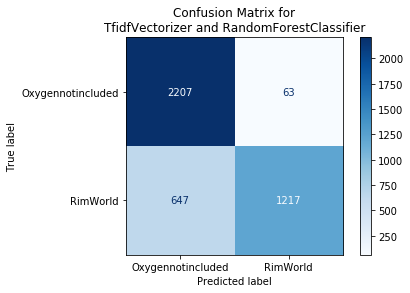

In [25]:
plot_confusion_matrix(rand_rf, X_test, y_test, cmap= "Blues", values_format = 'd');
plt.title("Confusion Matrix for\nTfidfVectorizer and RandomForestClassifier", fontsize=12)

In [26]:
pred_proba_rf = [i[1] for i in rand_rf.predict_proba(X_test)]

pred_df_rf = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba_rf})

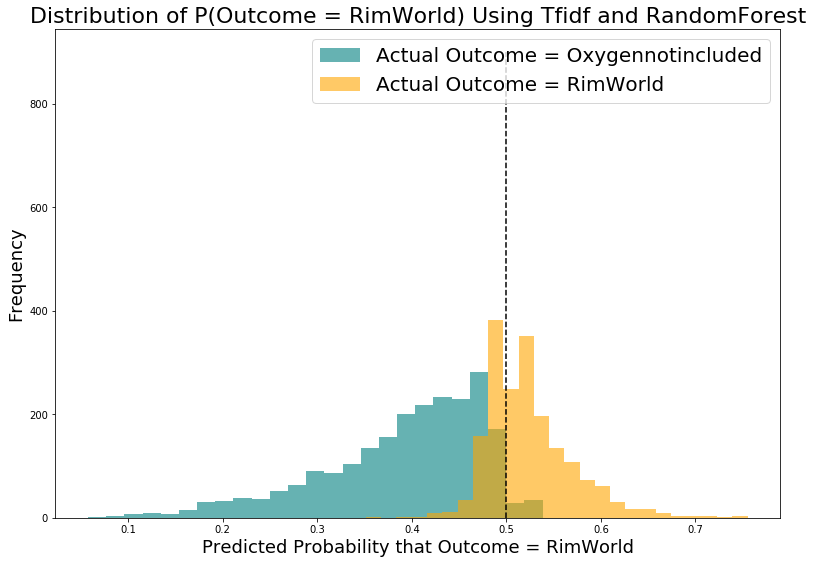

In [27]:
# Code adapted from global lect: Classification Metrics II

# Create figure.
plt.figure(figsize = (13,9))

# Create two histograms of observations.
plt.hist(pred_df_rf[pred_df_rf['true_values'] == 'Oxygennotincluded']['pred_probs'],
         bins=25,
         color='teal',
         alpha = 0.6,
         label='Actual Outcome = Oxygennotincluded')
plt.hist(pred_df_rf[pred_df_rf['true_values'] == 'RimWorld']['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Actual Outcome = RimWorld')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 900,
           color='black',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = RimWorld) Using Tfidf and RandomForest', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = RimWorld', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

# TfidfVectorizer and LogisticRegression

In [28]:
pipe_logreg = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

params_logreg = {
    'tvec__max_features': [10_000, 15_000],
    'tvec__stop_words': ['english'],
    'tvec__max_df': [1.0, 0.98],
    'logreg__C': [1.0, 0.95],
    'logreg__solver': ['liblinear']
}

In [29]:
cross_val_score(pipe_logreg, X_train, y_train, scoring='accuracy').mean()

0.925074984710276

In [30]:
gs_logreg = GridSearchCV(pipe_logreg,
                      params_logreg,
                      cv = 5,
                      verbose = 1)

In [31]:
%%time
gs_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   43.0s finished


CPU times: user 53 s, sys: 702 ms, total: 53.7 s
Wall time: 44.2 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': [1.0, 0.95],
                         'logreg__solver': ['liblinear'],
                         'tvec__max_df': [1.0, 0.98],
                         'tvec__max_features': [10000, 15000],
                         'tvec__stop_words': ['english']},
             verbose=1)

In [32]:
gs_logreg.best_params_

{'logreg__C': 0.95,
 'logreg__solver': 'liblinear',
 'tvec__max_df': 1.0,
 'tvec__max_features': 10000,
 'tvec__stop_words': 'english'}

In [33]:
gs_logreg.score(X_train, y_train), gs_logreg.score(X_test, y_test)

(0.9579804822969594, 0.9252539912917271)

In [34]:
preds_logreg = gs_logreg.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds_logreg).ravel()

Text(0.5, 1.0, 'Confusion Matrix for\nTfidfVectorizer and LogisticRegression')

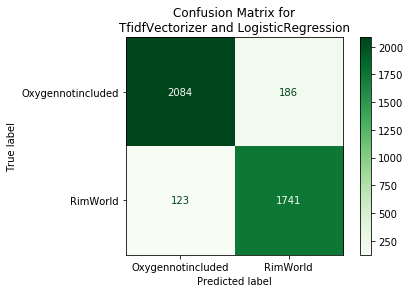

In [35]:
plot_confusion_matrix(gs_logreg, X_test, y_test, cmap= "Greens", values_format = 'd');
plt.title("Confusion Matrix for\nTfidfVectorizer and LogisticRegression", fontsize=12)

In [36]:
pred_proba_lr = [i[1] for i in gs_tvec.predict_proba(X_test)]

pred_df_lr = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba_lr})

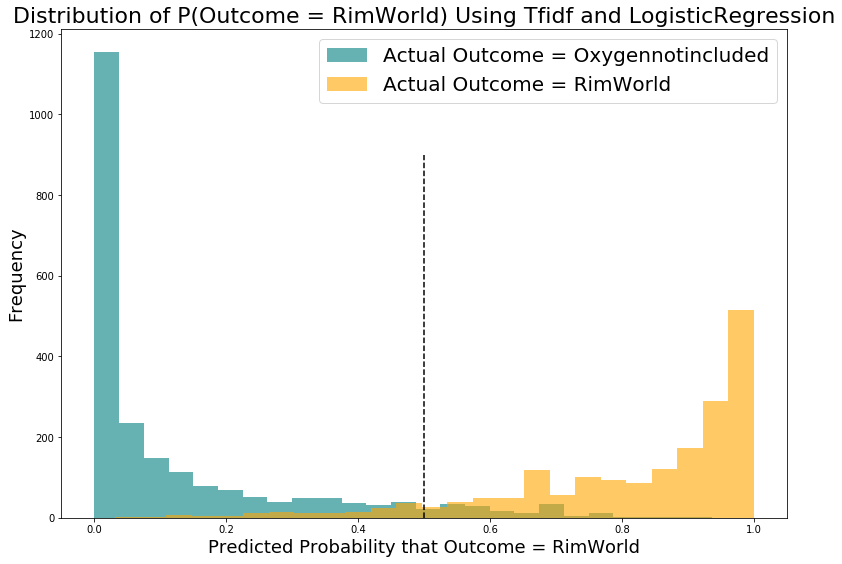

In [37]:
# Code adapted from global lect: Classification Metrics II

# Create figure.
plt.figure(figsize = (13,9))

# Create two histograms of observations.
plt.hist(pred_df_lr[pred_df_lr['true_values'] == 'Oxygennotincluded']['pred_probs'],
         bins=25,
         color='teal',
         alpha = 0.6,
         label='Actual Outcome = Oxygennotincluded')
plt.hist(pred_df_lr[pred_df_lr['true_values'] == 'RimWorld']['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Actual Outcome = RimWorld')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 900,
           color='black',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = RimWorld) Using Tfidf and LogisticRegression', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = RimWorld', fontsize=18)

# Create legend.
plt.legend(fontsize=20);